In [1]:
from openai_api import client

from crawler import crawl, TextToCSVClass, get_shortened
import pandas as pd
import tiktoken

In [2]:
domain = "jumparena.sk"  # <- put your domain to be crawled
full_url = "https://jumparena.sk/"  # <- put your domain to be crawled with https or http

In [3]:
crawl(full_url)
TextToCSVClass(domain).to_csv()

https://jumparena.sk/
https://jumparena.sk/oslavy
https://jumparena.sk/reservation/2
https://jumparena.sk/city/ke
https://jumparena.sk/bude-ta-zaujimat
EXCLUDED https://jumparena.sk/download/formular-pri-prevzati-Jump-sk-ba.pdf
EXCLUDED https://jumparena.sk/download/jedalny_listok.pdf
EXCLUDED https://jumparena.sk/download/Prevadzkovy-poriadok-JUMP-ARENA-sk-ba.pdf
https://jumparena.sk/freejump
https://jumparena.sk/reservation
https://jumparena.sk/teambuilding
https://jumparena.sk/city/ba
https://jumparena.sk/kontakt
https://jumparena.sk/gdpr
https://jumparena.sk/vstupne-a-akcie
https://jumparena.sk/prid-vyskusat
EXCLUDED https://jumparena.sk/download/letak_pre_skoly_jumparena.pdf
https://jumparena.sk/ponuka-pre-skoly
EXCLUDED https://jumparena.sk/download/jedalny_listok.pdf
EXCLUDED https://jumparena.sk/download/jedalny_listok_en.pdf
EXCLUDED https://jumparena.sk/download/letak_pre_skoly_jumparena.pdf
https://jumparena.sk


<Axes: >

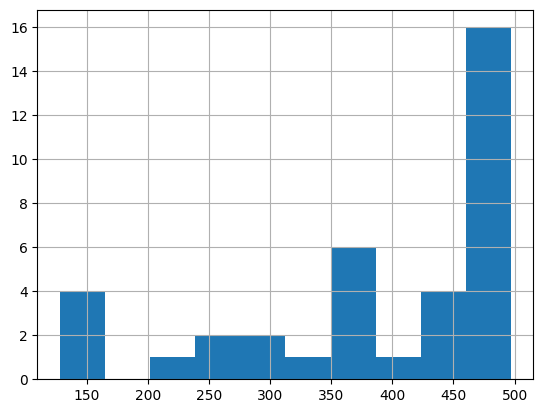

In [4]:
tokenizer = tiktoken.get_encoding("cl100k_base")
shortened = get_shortened()
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [9]:
df['embeddings'] = df.text.apply(lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-y7iMp***************************************7Gvv. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}